# Oscilloskope USBTCM utility

In [61]:
import matplotlib.pyplot as plt
import sys
import os
import time
import h5py
import numpy as np
import glob

# Step 1:
# Run "Record" on the oscilloscope
# and wait for 508 frames to be acquired.
# Step 2:
# Run this cell to initialize grabbing.
# This requires rw access to the /dev/usbtmc1 device.
# This can be granted by for example: 'sudo chmod a+rw /dev/usbtmc1'

class UsbTmcDriver:

    def __init__(self, device):
        self.device = device
        self.FILE = os.open(device, os.O_RDWR)
 
    def write(self, command):
        os.write(self.FILE, command);
 
    def read(self, length = 500):
        return os.read(self.FILE, length)
 
    def getName(self):
        self.write("*IDN?")
        return self.read(300)
 
    def sendReset(self):
        self.write("*RST")  # Be carefull, this real resets an oscilloscope

# Looking for USBTMC device
def getDeviceList(): 
    dirList=os.listdir("/dev")
    result=list()

    for fname in dirList:
        if(fname.startswith("usbtmc")):
            result.append("/dev/" + fname)

    return result

# looking for oscilloscope
devices =  getDeviceList()
# initiate oscilloscope
osc = UsbTmcDriver(devices[0])
print osc.getName()


RIGOL TECHNOLOGIES,DS2072A,DS2D204202923,00.03.05.SP4



## Reading buffer with stored records

In [30]:
osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE NORM')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 1400')

with h5py.File('data.h5', 'w') as hf:
    osc.write(':WAV:XINC?')
    xinc = float(osc.read(100))
    print 'XINC:', xinc
    osc.write(':WAV:YINC?')
    yinc = float(osc.read(100))
    print 'YINC:', yinc
    osc.write(':FUNC:WREP:FEND?') # get number of last frame
    frames = int(osc.read(100))
    print 'FRAMES:', frames
    hf.create_dataset('FRAMES', data=(frames)) # write number of frames
    hf.create_dataset('XINC', data=(xinc)) # write axis parameters
    hf.create_dataset('YINC', data=(yinc))
    osc.write(':FUNC:WREP:FCUR 1') # skip to n-th frame
    time.sleep(0.5)
    for n in range(1,frames+1):
        osc.write(':FUNC:WREP:FCUR ' + str(n)) # skip to n-th frame
        time.sleep(0.1)

        osc.write(':WAV:DATA?') # read data
        #time.sleep(0.4)
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave3 = bytearray(osc.read(500))
        #wave4 = bytearray(osc.read(500))
        #wave = np.concatenate((wave1[11:],wave2[:(500-489)],wave3[:(700-489)]))
        wave = np.concatenate((wave1[11:],wave2,wave3[:-1]))
        hf.create_dataset(str(n), data=wave)
    

XINC: 5e-07
YINC: 0.0004
FRAMES: 7


XINC: 1e-06    YINC: 0.002    FRAMES: 9
1 122 134 89245
2 96 142 89127
3 122 134 89341
4 120 135 89359
5 122 135 89370
6 119 137 89269
7 119 137 89226
8 112 136 89280
9 114 139 89188


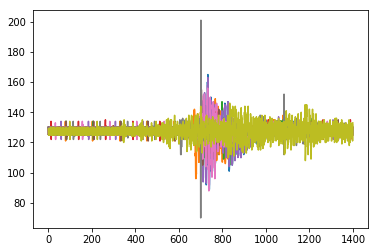

In [65]:
%matplotlib inline 

with h5py.File('data1.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC')), '   FRAMES:', np.array(hf.get('FRAMES'))
    frames = np.array(hf.get('FRAMES'))
    for n in range(1,frames+1):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        if n < 10:
            print n, minimum, maximum, suma

## Read repeatedly records from oscilloscope

This should be run after the initialization step.
Timeout at the end should be enlarged if not all 508 frames are transferred.

In [66]:
for f in glob.iglob("./*.h5"): # delete all .h5 files 
    #print 'Deleting', f
    os.remove(f)

filename = 1
while True:
    osc.write(':WAV:SOUR CHAN1')
    osc.write(':WAV:MODE NORM')
    osc.write(':WAV:FORM BYTE')
    osc.write(':WAV:POIN 1400')

    osc.write(':WAV:XINC?')
    xinc = float(osc.read(100))
    print 'XINC:', xinc,
    osc.write(':WAV:YINC?')
    yinc = float(osc.read(100))
    print 'YINC:', yinc,
    
    #osc.write(':FUNC:WREC:FEND?') # get number of last frame
    #end = int(osc.read(100))
    #while end<508:
    #    time.sleep(10)
    #    osc.write(':FUNC:WREC:FEND?') # get number of last frame
    #    end = int(osc.read(100))
    #    print 'Waiting', end

    osc.write(':FUNC:WREP:FEND?') # get number of last frame
    frames = int(osc.read(100))
    print 'FRAMES:', frames, 'SUBRUN', filename

    with h5py.File('data'+str(filename)+'.h5', 'w') as hf:       
        hf.create_dataset('FRAMES', data=(frames)) # write number of frames
        hf.create_dataset('XINC', data=(xinc)) # write axis parameters
        hf.create_dataset('YINC', data=(yinc))
        osc.write(':FUNC:WREP:FCUR 1') # skip to n-th frame
        time.sleep(0.5)
        for n in range(1,frames+1):
            osc.write(':FUNC:WREP:FCUR ' + str(n)) # skip to n-th frame
            time.sleep(0.1)

            osc.write(':WAV:DATA?') # read data
            #time.sleep(0.4)
            wave1 = bytearray(osc.read(500))
            wave2 = bytearray(osc.read(500))
            wave3 = bytearray(osc.read(500))
            #wave4 = bytearray(osc.read(500))
            #wave = np.concatenate((wave1[11:],wave2[:(500-489)],wave3[:(700-489)]))
            wave = np.concatenate((wave1[11:],wave2,wave3[:-1]))
            hf.create_dataset(str(n), data=wave)
    filename = filename + 1
    osc.write(':FUNC:WREC:OPER REC') # start recording
    #time.sleep(1800) # delay for capturing
    input("Press Enter to continue...")

XINC: 1e-06 YINC: 0.002 FRAMES: 2 SUBRUN 1
Press Enter to continue...


SyntaxError: unexpected EOF while parsing (<string>, line 0)

## Read number of waveforms and write it to a file

In [ ]:
runs = 10

%matplotlib notebook
fig,ax = plt.subplots(1,1)

osc.write(':WAV:XINC?')
xinc = float(osc.read(100))
print 'XINC:', xinc
osc.write(':WAV:YINC?')
yinc = float(osc.read(100))
print 'YINC:', yinc

osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE NORM')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 700')

with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('XINC', data=(xinc))
    hf.create_dataset('YINC', data=(yinc))
    #hf.create_dataset('YINC', bytearray(yinc))
    for n in range(runs):
        #osc.write(':RUN')
        # waiting for SINGLE trigger
        osc.write(':SING')
        osc.write(':TRIG:STAT?')
        while (osc.read(4) != 'STOP'):
            osc.write(':TRIG:STAT?')
        time.sleep(0.1)

        #osc.write(':STOP')
        osc.write(':WAV:DATA?')
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        #osc.write(':WAV:RES')
        hf.create_dataset(str(n), data=wave)
        fig.clf()
        plt.ylim(0, 255)
        plt.plot(wave)
        fig.canvas.draw()

 

## Read waveforms from the file

XINC: 5e-07    YINC: 0.0004


IndexError: too many indices for array

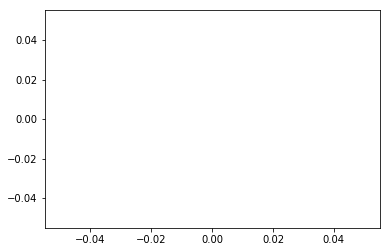

In [45]:
%matplotlib inline 

with h5py.File('data1.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC'))
    for n in range(10):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        print minimum, maximum, suma


## Capture waveforms and plot it

<IPython.core.display.Javascript object>


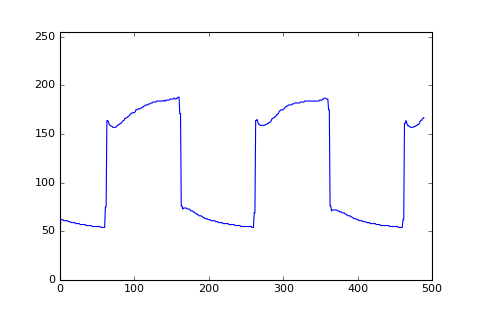

In [98]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)

# looking for oscilloscope
devices =  getDeviceList()
# initiate oscilloscope
osc = UsbTmcDriver(devices[0])

df = pd.Series(0) # Create a new dataframe

for n in range(10):
    # waiting for SINGLE trigger
    osc.write(':SINGLE')
    osc.write(':TRIG:STAT?')
    while (osc.read(4) != 'STOP'):
        osc.write(':TRIG:STAT?')

    #osc.write(':STOP')
    osc.write(':WAV:SOUR CHAN1')
    osc.write(':WAV:MODE NORM')
    osc.write(':WAV:FORM BYTE')
    osc.write(':WAV:DATA?')

    #wave = map(float, osc.read(100).split(','))
    wave = bytearray(osc.read(1400))

    fig.clf()
    plt.ylim(0, 255)
    plt.plot(wave[10:])
    fig.canvas.draw()
    time.sleep(0.1)


In [19]:
runs = 10

osc.write(':WAV:XINC?')
xinc = float(osc.read(100))
print 'XINC:', xinc
osc.write(':WAV:YINC?')
yinc = float(osc.read(100))
print 'YINC:', yinc

osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE NORM')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 700')

with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('XINC', data=(xinc))
    hf.create_dataset('YINC', data=(yinc))
    #hf.create_dataset('YINC', bytearray(yinc))
    for n in range(runs):
        #osc.write(':RUN')
        # waiting for SINGLE trigger
        osc.write(':SING')
        osc.write(':TRIG:STAT?')
        while (osc.read(4) != 'STOP'):
            osc.write(':TRIG:STAT?')
        time.sleep(0.2)

        #osc.write(':STOP')
        osc.write(':WAV:DATA?')
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        #osc.write(':WAV:END')
        hf.create_dataset(str(n), data=wave)

%matplotlib inline 

with h5py.File('data.h5','r') as hf:
    #print('List of arrays in this file: \n', hf.keys())
    print 'XINC:', np.array(hf.get('XINC')), '   YINC:', np.array(hf.get('YINC'))
    for n in range(10):
        data = hf.get(str(n))
        np_data = np.array(data)
        plt.plot(np_data)
        #print np_data
        maximum = 0
        minimum = 255
        suma = 0
        for i in range(700):
            if np_data[i] > maximum:
                maximum = np_data[i]
            if np_data[i] < minimum:
                minimum = np_data[i]
            suma = suma + np_data[i]
        print minimum, maximum, suma


XINC: 5e-07
YINC: 0.0004


OSError: [Errno 110] Connection timed out

<IPython.core.display.Javascript object>


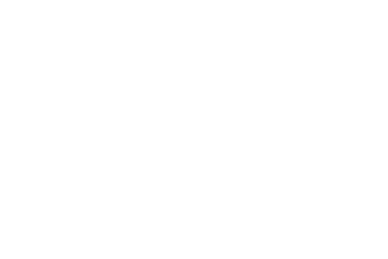

XINC: 5e-07
YINC: 0.0004


KeyboardInterrupt: 

In [20]:
runs = 1

%matplotlib notebook
fig,ax = plt.subplots(1,1)

osc.write(':WAV:XINC?')
xinc = float(osc.read(100))
print 'XINC:', xinc
osc.write(':WAV:YINC?')
yinc = float(osc.read(100))
print 'YINC:', yinc

osc.write(':WAV:SOUR CHAN1')
osc.write(':WAV:MODE NORM')
osc.write(':WAV:FORM BYTE')
osc.write(':WAV:POIN 700')

with h5py.File('data.h5', 'w') as hf:
    hf.create_dataset('XINC', data=(xinc))
    hf.create_dataset('YINC', data=(yinc))
    #hf.create_dataset('YINC', bytearray(yinc))
    for n in range(runs):
        #osc.write(':RUN')
        # waiting for SINGLE trigger
        #osc.write(':SING')
        #osc.write(':TRIG:STAT?')
        #while (osc.read(4) != 'STOP'):
        #    osc.write(':TRIG:STAT?')
        #time.sleep(0.1)

        #osc.write(':STOP')
        osc.write(':WAV:DATA?')
        wave1 = bytearray(osc.read(500))
        wave2 = bytearray(osc.read(500))
        wave = np.concatenate((wave1[11:],wave2[:(700-489)]))
        #osc.write(':WAV:RES')
        hf.create_dataset(str(n), data=wave)
        fig.clf()
        plt.ylim(0, 255)
        plt.plot(wave)
        fig.canvas.draw()

 